In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf

In [2]:
# port old functions from the other notebook 
# now, lets build your circuit in scikit-rf 

def get_network_90deg_hybrid(freq, z0=50, name='90deg hybrid 1'):
    """
    freq: scikit-rf frequency object
    z0: can be a single value or a list corrisponding to the ports 

    Note: using Pozer hybrid port naming and S matrix definition 
       1 |     |2
       4 |     |3   
    """
    row1 = [0, 1j, 1, 0]
    row2 = [1j, 0, 0, 1]
    row3 = [1, 0, 0, 1j]
    row4 = [0, 1, 1j, 0]

    S = -np.array([row1, row2, row3, row4])/np.sqrt(2)

    s_hybrid = np.zeros((freq.f.shape[0], 4, 4), dtype=complex)
    s_hybrid[0, :, :] = S

    return rf.Network(frequency=freq, s=s_hybrid, z0=z0, name=name)

def get_network_wilkinson_power_divider(freq, z0=50, name='pwrdv 1'):
    row1 = [0, 1j, 1j]
    row2 = [1j, 0, 0]
    row3 = [1j, 0, 0]

    S = -np.array([row1, row2, row3])/np.sqrt(2)

    s_wpd = np.zeros((freq.f.shape[0], 3, 3), dtype=complex)
    s_wpd[0, :, :] = S

    return rf.Network(frequency=freq, s=s_wpd, z0=z0, name=name)

def get_network_phase_shifter(phase_shift, freq, z0=50, name='ps 1'):
    factor = np.exp(1j*phase_shift)
    S_ps = np.array([[0, factor], [factor, 0]], dtype='complex') 
    s_phase_shifter = np.zeros((len(freq.f), 2, 2), dtype=complex)
    s_phase_shifter[0, :, :] = S_ps
    return rf.Network(frequency=freq, s=s_phase_shifter, z0=z0, name=name)

def get_network_series_resistor(freq, R, z0=50, name='resistor 1'):
    factor = 1 / (2*z0 + R)
    S_r = factor*np.array([[R, 2*z0], [2*z0, R]], dtype='complex') 
    s_resistor = np.zeros((len(freq.f), 2, 2), dtype=complex)
    s_resistor[0, :, :] = S_r
    return rf.Network(frequency=freq, s=s_resistor, z0=z0, name=name)


def get_network_3port_ant(freq, loss_dB, z0=50, name='lossy 3 port ant'):
    S21 = np.sqrt(10**(-loss_dB/10)/2)
    S = np.array([[0, S21, S21],
                  [S21, 0, 0],
                  [S21, 0, 0]], dtype=complex)
    
    s_3port = np.zeros((len(freq.f), 3, 3), dtype=complex)
    s_3port[0, :, :] = S

    return rf.Network(frequency=freq, s=s_3port, z0=z0, name=name)

def get_network_matched_lossy_tl(freq, line_freq_hz, z0=50, length_m=1, alpha_db_per_m=0.0, eps_eff=1.0, name='lossy TL'):
    """
    Return a 2x2 S matrix (complex) for a matched (Zc=Z0) lossy TL segment at frequency f_hz.
    - f_hz: scalar frequency in Hz
    - length_m: length in meters
    - alpha_db_per_m: attenuation in dB per meter (power dB/m). Can be 0.
    - eps_eff: effective permittivity (for phase velocity)
    Returns: s (2x2 complex numpy array), gamma (complex propagation constant, Np/m + j rad/m)
    """
    c = 299792458.0
    # convert power dB/m to amplitude Np/m
    # alpha_np = alpha_db_per_m * ln(10) / 40
    alpha_np_per_m = alpha_db_per_m * np.log(10.0) / 40.0

    # phase constant beta
    vph = c / np.sqrt(eps_eff)
    beta = 2.0 * np.pi * line_freq_hz / vph

    gamma = alpha_np_per_m + 1j*beta

    S21 = np.exp(-gamma * length_m)
    S = np.array([[0+0j, S21],
                  [S21,   0+0j]], dtype=complex)
    
    s_line = np.zeros((len(freq.f), 2, 2), dtype=complex)
    s_line[0, :, :] = S
    return rf.Network(frequency=freq, s=s_line, z0=z0, name=name)

    

def get_network_wunit(freq, z0, phase_shifter_phase_shift, return_circuit=False, name='wunit 1'):

    """
    Note: port 1 connects to 90dB Hyb 1 port 1
          port 4 connects to 90dB Hyb 1 port 4
          port 2 connects to 90dB Hyb 2 port 2
          port 3 connects to 90 dBHyb 2 port 3
    """

    # build ports
    port1 = rf.Circuit.Port(freq, f'{name}_port1', z0=z0)
    port2 = rf.Circuit.Port(freq, f'{name}_port2', z0=z0)
    port3 = rf.Circuit.Port(freq, f'{name}_port3', z0=z0)
    port4 = rf.Circuit.Port(freq, f'{name}_port4', z0=z0)

    # get composite networks 
    hybrid1 = get_network_90deg_hybrid(freq=freq, z0=z0, name=f'{name}_90deg hybrid 1')
    hybrid2 = get_network_90deg_hybrid(freq=freq, z0=z0, name=f'{name}_90deg hybrid 2')
    phase_shifter = get_network_phase_shifter(phase_shift=phase_shifter_phase_shift, freq=freq, z0=z0, name=f'{name}_ps 1')

    # wire together 
    connections = [
        [(port1, 0), (hybrid1, 0)],
        [(hybrid2, 1), (port2, 0)],
        [(hybrid2, 2), (port3, 0)],
        [(port4, 0), (hybrid1, 3)],
        [(hybrid1, 1), (hybrid2, 0)],
        [(hybrid1, 2), (phase_shifter, 0)],
        [(phase_shifter, 1), (hybrid2, 3)],
    ]

    cir = rf.Circuit(connections=connections, name=name)
    ntw = cir.network
    if return_circuit:
        return ntw, cir
    else:
        return ntw
    

def get_circuit_wunit_ring(freq, z0, phase_shifter_phase_shift_array, return_circuit=False, name='wUnitRing1'):
    """
    builds circuit from generator up to TWA out. 4 port device.
    Port 1: to WPD from generator. 
    Port 2: from TWA return 1 to wunit 1 port 1
    Port 3: from TWA return 2 to wunit 2 port 1
    Port 4: from  wunit3 port 2 to TWA antenna 
    """
    # build the wunits
    wunit1 = get_network_wunit(freq, z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[0], return_circuit=False, name=f'{name}_wunit 1')
    wunit2 = get_network_wunit(freq, z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[1], return_circuit=False, name=f'{name}_wunit 2')
    wunit3 = get_network_wunit(freq, z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[2], return_circuit=False, name=f'{name}_wunit 3')
    
    # build Wilkinson power divider 
    wpd1 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 1')

    # build ports 
    port1 = rf.Circuit.Port(freq, f'{name}_port1', z0=z0)
    port2 = rf.Circuit.Port(freq, f'{name}_port2', z0=z0)
    port3 = rf.Circuit.Port(freq, f'{name}_port3', z0=z0)
    port4 = rf.Circuit.Port(freq, f'{name}_port4', z0=z0)

    # dummy load monitor ports to connect to wunits
    dummy_load_port1 = rf.Circuit.Port(freq, f'{name}_DL_port1', z0=z0)
    dummy_load_port2 = rf.Circuit.Port(freq, f'{name}_DL_port2', z0=z0)
    dummy_load_port3 = rf.Circuit.Port(freq, f'{name}_DL_port3', z0=z0)

    # wire together 
    connections = [
        [(port1,0), (wpd1, 0)],
        [(wpd1,1), (wunit1,3)],
        [(wpd1,2), (wunit2,3)],
        [(port2, 0), (wunit1,0)],
        [(port3, 0), (wunit2,0)],
        [(wunit1,1), (wunit3,0)],
        [(wunit2,1), (wunit3,3)],
        [(port4,0), (wunit3,1)],
        [(dummy_load_port1,0), (wunit1,2)],
        [(dummy_load_port2,0), (wunit2,2)],
        [(dummy_load_port3,0), (wunit3,2)]
    ]

    cir = rf.Circuit(connections=connections, name=name)
    ntw = cir.network
    if return_circuit:
        return ntw, cir
    else:
        return ntw
    
def get_circuit_wunit2wpd2_ring(freq, z0, phase_shifter_phase_shift_array, return_circuit=False, name='wUnitRing1'):
    """
    builds circuit from generator up to TWA out. 4 port device, plus 2 dummy loads.
    Port 1: to WPD from generator. 
    use_3_way_node = True replaces the 3-way center fed TWA feed node with a perfect T so scikit-rf can get currents.  
    """
    # # build the junits
    wunit1 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[0], return_circuit=False, name=f'{name}_wunit 1')
    wunit2 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[1], return_circuit=False, name=f'{name}_wunit 2')
    phase_shifter = get_network_phase_shifter(phase_shift=phase_shifter_phase_shift_array[2], freq=freq, z0=z0, name=f'{name}_ps 1')
    
    # # build Wilkinson power divider 
    wpd1 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 1')
    wpd2 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 2')

    # # build ports 
    port1 = rf.Circuit.Port(freq, f'{name}_port1', z0=z0)
    port2 = rf.Circuit.Port(freq, f'{name}_port2', z0=z0)
    port3 = rf.Circuit.Port(freq, f'{name}_port3', z0=z0)
    port4 = rf.Circuit.Port(freq, f'{name}_port4', z0=z0)

    # # dummy load monitor ports to connect to junits
    dummy_load_port1 = rf.Circuit.Port(freq, f'{name}_DL_port1', z0=z0)
    dummy_load_port2 = rf.Circuit.Port(freq, f'{name}_DL_port2', z0=z0)

    connections = [
        [(port1,0), (wpd1, 0)],
        [(wpd1,1), (wunit1,3)],
        [(wpd1,2), (wunit2,3)],
        [(port2, 0), (wunit1,0)],
        [(port3, 0), (wunit2,0)],
        [(wunit1,1), (wpd2,1)],
        [(wunit2,1), (wpd2,2)],
        [(phase_shifter, 1), (port4, 0)],
        [(phase_shifter, 0), (wpd2, 0)],
        [(dummy_load_port1,0), (wunit1,2)],
        [(dummy_load_port2,0), (wunit2,2)],
    ]
    
    cir = rf.Circuit(connections=connections, name=name)
    ntw = cir.network
    if return_circuit:
        return ntw, cir
    else:
        return ntw


def get_circuit_loaded_wunit2wpd2_ring_1ant(freq, z0, phase_shifter_phase_shift_array, R, return_circuit=False, name='wunit 3 port ant'):
    """
    builds circuit from generator up to TWA out. 1 port device, plus 2 dummy loads.
    Port 1: to WPD from generator.   
    """
    # # build the junits
    wunit1 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[0], return_circuit=False, name=f'{name}_wunit 1')
    wunit2 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[1], return_circuit=False, name=f'{name}_wunit 2')
    phase_shifter = get_network_phase_shifter(phase_shift=phase_shifter_phase_shift_array[2], freq=freq, z0=z0, name=f'{name}_ps 1')
    
    # # build Wilkinson power divider 
    wpd1 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 1')
    wpd2 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 2')

    # build the antenna load. There are two due to the center fed TWA 
    ant = get_network_3port_ant(freq, loss_dB=R, z0=50, name=f'{name}lossy 3 port ant')

    # # build ports 
    port1 = rf.Circuit.Port(freq, f'{name}_port1', z0=z0)

    # # dummy load monitor ports to connect to junits
    dummy_load_port1 = rf.Circuit.Port(freq, f'{name}_DL_port1', z0=z0)
    dummy_load_port2 = rf.Circuit.Port(freq, f'{name}_DL_port2', z0=z0)

    # # wire together, using a perfect T in place of the three-way node feedinmg the TWA if requested. 

    connections = [
        [(port1,0), (wpd1, 0)],
        [(wpd1,1), (wunit1,3)],
        [(wpd1,2), (wunit2,3)],
        [(ant, 1), (wunit1,0)],
        [(ant, 2), (wunit2,0)],
        [(wunit1,1), (wpd2,1)],
        [(wunit2,1), (wpd2,2)],
        [(phase_shifter, 1), (ant, 0)],
        [(phase_shifter, 0), (wpd2, 0)],
        [(dummy_load_port1,0), (wunit1,2)],
        [(dummy_load_port2,0), (wunit2,2)],
    ]

    cir = rf.Circuit(connections=connections, name=name)
    ntw = cir.network
    if return_circuit:
        return ntw, cir
    else:
        return ntw
    
def get_circuit_loaded_2wunit_isolated_rings(freq, z0, phase_shifter_phase_shift_array, R, return_circuit=False, name='wUnitIsorings'):
    """
    builds circuit from generator up to TWA out. 1 port device, plus 2 dummy loads.
    Port 1: to WPD from generator. 
    use_3_way_node = True replaces the 3-way center fed TWA feed node with a perfect T so scikit-rf can get currents.  
    """
    # # build the wunits
    wunit1 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[0], return_circuit=False, name=f'{name}_wunit 1')
    wunit2 = get_network_wunit(freq=freq, z0=z0, phase_shifter_phase_shift=phase_shifter_phase_shift_array[0], return_circuit=False, name=f'{name}_wunit 2')
    phase_shifter1 = get_network_phase_shifter(phase_shift=phase_shifter_phase_shift_array[1], freq=freq, z0=z0, name=f'{name}_ps 1')
    phase_shifter2 = get_network_phase_shifter(phase_shift=phase_shifter_phase_shift_array[1], freq=freq, z0=z0, name=f'{name}_ps 2')

    # build the antenna load. There are two due to the center fed TWA 
    ant1 = get_network_matched_lossy_tl(freq, line_freq_hz=96e6, z0=50, length_m=1, alpha_db_per_m=R, eps_eff=1.0, name=f'{name}lossy TL 1')
    ant2 = get_network_matched_lossy_tl(freq, line_freq_hz=96e6, z0=50, length_m=1, alpha_db_per_m=R, eps_eff=1.0, name=f'{name}lossy TL 2')
    
    wpd1 =  get_network_wilkinson_power_divider(freq, z0=z0, name=f'{name}wpwrdv 1')
    # # build ports 
    port1 = rf.Circuit.Port(freq, f'{name}_port1', z0=z0)

    # # dummy load monitor ports to connect to junits
    dummy_load_port1 = rf.Circuit.Port(freq, f'{name}_DL_port1', z0=z0)
    dummy_load_port2 = rf.Circuit.Port(freq, f'{name}_DL_port2', z0=z0)

    # build connections 
    connections = [
        [(port1,0), (wpd1, 0)],
        [(wpd1, 1), (wunit1, 3)],
        [(wpd1,2), (wunit2, 3)],
        [(wunit1,1), (phase_shifter1, 0)],
        [(wunit2,1), (phase_shifter2, 0)],
        [(wunit1,2), (dummy_load_port1, 0)],
        [(wunit2,2), (dummy_load_port2, 0)],
        [(ant1, 1), (wunit1, 0)],
        [(ant2, 1), (wunit2, 0)],
        [(phase_shifter1, 1), (ant1,0)],
        [(phase_shifter2, 1), (ant2,0)]
    ]
    cir = rf.Circuit(connections=connections, name=name)
    ntw = cir.network
    if return_circuit:
        return ntw, cir
    else:
        return ntw

def branch_currents(circuit, power, phase):
    """
    Returns the per-branch currents (complex phasors) from a scikit-rf Circuit.
    Magnitude is in Amps (peak), sign convention: positive means
    current entering first component in the connection tuple.
    """
    I_all = circuit.currents(power, phase)  # shape: (n_freqs, 2*N_connections)
    n_freqs, n_cols = I_all.shape
    n_connections = n_cols // 2

    # Take only the first entry of each pair (branch current into first port)
    I_branch = I_all[:, 0::2]

    # Optional: sanity check — ensure I_first ≈ -I_second for each branch
    for k in range(n_connections):
        diff = I_all[:, 2*k] + I_all[:, 2*k + 1]
        if np.max(np.abs(diff)) > 1e-6:
            print(f"Warning: branch {k} currents not equal and opposite")

    return I_branch

def branch_voltages(circuit, power, phase):
    """
    Returns the per-branch voltages (complex phasors) from a scikit-rf Circuit.
    Magnitude is in volts (peak)
    """
    V_all = circuit.voltages(power, phase)  # shape: (n_freqs, 2*N_connections)
    n_freqs, n_cols = V_all.shape
    n_connections = n_cols // 2

    # Take only the first entry of each pair (branch voltage into first port)
    V_branch = V_all[:, 0::2]

    # Optional: sanity check — ensure I_first ≈ -I_second for each branch
    # for k in range(n_connections):
    #     diff = V_all[:, 2*k] + V_all[:, 2*k + 1]
    #     if np.max(np.abs(diff)) > 1e-6:
    #         print(f"Warning: branch {k} currents not equal and opposite")

    return V_branch

def branch_powers(circuit, power, phase):
    currents = branch_currents(circuit, power, phase)
    voltages = branch_voltages(circuit, power, phase)

    powers = 0.5*np.real(voltages * np.conj(currents))

    return powers

In [66]:
# confirm this all works 
# try out the three port lossy antenna model 
#get_circuit_loaded_wunit2wpd2_ring_1ant(freq, z0, phase_shifter_phase_shift_array, R, return_circuit=False, name='wunit 3 port ant')
f = np.array([96]) # not important, assume our componants are chosen for this frequency. 
freq = rf.Frequency.from_f(f, unit='MHz')

antload = .2 # db ohm, keep < z0 = 50 for small loading 

# test out loaded junit circuit model 

#phase = [np.pi/2, np.pi/2, np.pi/2]

phase_array = np.linspace(0, 2*np.pi, 400)
# dphi = 0
# twa_return1_power_factor = 1
# twa_return2_power_factor = 1

# response arrays for plotting 
generator_phasor_array = np.zeros_like(phase_array, dtype=complex)


dummy_load1_phasor_array = np.zeros_like(phase_array, dtype=complex)
dummy_load2_phasor_array = np.zeros_like(phase_array, dtype=complex)

# make other storage arrays for internal powers within antenna ring network 

int_generator_phasor_array_0 = np.zeros_like(phase_array)
wpd1_out_phasor_array_1 = np.zeros_like(phase_array)
wpd1_out_phasor_array_2 = np.zeros_like(phase_array)
twa_return_phasor_array_3 = np.zeros_like(phase_array)
twa_return_phasor_array_4 = np.zeros_like(phase_array)
twa_infeed_phasor_array_7 = np.zeros_like(phase_array)

twa_return_phase_array_3 = np.zeros_like(phase_array)
twa_return_phase_array_4 = np.zeros_like(phase_array)

# junit_ring_network = get_circuit_junit_ring(freq, z0=50, phase_shifter_phase_shift_array=phase, return_circuit=False, name='jUnitRing1')
# s_junit_ring_network = junit_ring_network.s[0,:,:]


for i in range(phase_array.shape[0]):
    # grab the loaded j unit ring s matrix for the given phase shiftor phase. Allow the ring to set up the resonance correctly 
    loaded_j, loaded_j_circ = get_circuit_loaded_wunit2wpd2_ring_1ant(freq, z0=50, phase_shifter_phase_shift_array=[1.13*np.pi, 1.13*np.pi, phase_array[i]], R=antload, return_circuit=True, name='3 port lossy antenna')
    s_loaded_j_unit_ring_network = loaded_j.s[0,:,:]
    excitation = np.array([1,
                           0,
                           0]).T
    
    result = np.matmul(s_loaded_j_unit_ring_network, excitation)
    generator_phasor_array[i] = result[0]
    dummy_load1_phasor_array[i] = result[1]
    dummy_load2_phasor_array[i] = result[2]

    # now, probe the powers in the internal ports. 
    currents = branch_currents(circuit=loaded_j_circ, power=excitation, phase=excitation*0)
    voltages = branch_voltages(circuit=loaded_j_circ, power=excitation, phase=excitation*0)
    powers = branch_powers(circuit=loaded_j_circ, power=excitation, phase=excitation*0)
    
    # load up the power vectors 
    int_generator_phasor_array_0[i] = np.abs(powers[0][0])
    wpd1_out_phasor_array_1[i] = np.abs(powers[0][1])
    wpd1_out_phasor_array_2[i] = np.abs(powers[0][2])
    twa_return_phasor_array_3[i] = np.abs(powers[0][3])
    twa_return_phasor_array_4[i] = np.abs(powers[0][4])
    twa_infeed_phasor_array_7[i] = np.abs(powers[0][7])
    twa_return_phase_array_3[i] = np.arctan2(np.imag(powers[0][3]), np.real(powers[0][3]))/np.pi
    twa_return_phase_array_4[i] = np.arctan2(np.imag(powers[0][4]), np.real(powers[0][4]))/np.pi

Text(0.5, 1.0, 'Name: 3 port lossy antenna\n antenna load: 0.2 dB per half')

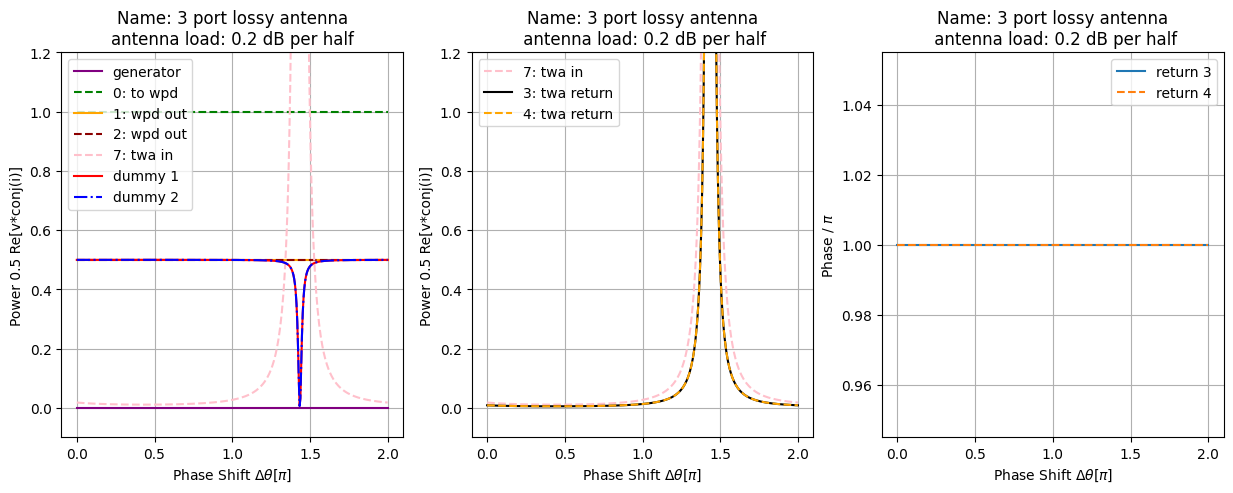

In [67]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(phase_array/np.pi, np.abs(generator_phasor_array)**2, label='generator', color='purple')
ax[0].plot(phase_array/np.pi, int_generator_phasor_array_0, label='0: to wpd',color='green', linestyle='--')
ax[0].plot(phase_array/np.pi, wpd1_out_phasor_array_1, label='1: wpd out',color='orange', linestyle='solid')
ax[0].plot(phase_array/np.pi, wpd1_out_phasor_array_2, label='2: wpd out',color='darkred', linestyle='--')
ax[0].plot(phase_array/np.pi, twa_infeed_phasor_array_7, label='7: twa in',color='pink', linestyle='--')

# plot the circulating power on the other axis
ax[1].plot(phase_array/np.pi, twa_infeed_phasor_array_7, label='7: twa in',color='pink', linestyle='--') 
ax[1].plot(phase_array/np.pi, twa_return_phasor_array_3, label='3: twa return',color='black')
ax[1].plot(phase_array/np.pi, twa_return_phasor_array_4, label='4: twa return',color='orange', linestyle='--')

ax[0].plot(phase_array/np.pi, np.abs(dummy_load1_phasor_array)**2, label='dummy 1', linestyle='solid', color='red')
ax[0].plot(phase_array/np.pi, np.abs(dummy_load2_phasor_array)**2, label='dummy 2', linestyle='-.', color='blue')

ax[0].set_xlabel('Phase Shift' r' $\Delta \theta [\pi$]')
ax[0].set_ylabel(r'Power 0.5 Re[v*conj(i)]')
ax[0].legend()
ax[0].set_ylim(-.1,1.2)
ax[1].set_ylim(-.1,1.2)
ax[0].grid()
title_string = f'{loaded_j.name}\nantenna load: {antload} dB per half'
ax[0].set_title(f'Name: {title_string}')

ax[1].set_xlabel('Phase Shift' r' $\Delta \theta [\pi$]')
ax[1].set_ylabel(r'Power 0.5 Re[v*conj(i)]')
ax[1].legend()
ax[1].grid()
title_string = f'{loaded_j.name}\n antenna load: {antload} dB per half'
ax[1].set_title(f'Name: {title_string}')


ax[2].plot(phase_array/np.pi, twa_return_phase_array_3, label='return 3')
ax[2].plot(phase_array/np.pi, twa_return_phase_array_4, label='return 4', linestyle='--')
ax[2].set_xlabel('Phase Shift' r' $\Delta \theta [\pi$]')
ax[2].set_ylabel(r'Phase / $\pi$')
ax[2].legend()
ax[2].grid()
title_string = f'{loaded_j.name}\n antenna load: {antload} dB per half'
ax[2].set_title(f'Name: {title_string}')

In [63]:
# now, do a 2D scan of the phase shifter sets. 

load = 0.2 # dB signal loss through model antenna. Z0 = 50 Ohm 

f = np.array([96]) # not important, assume our componants are chosen for this frequency. 
freq = rf.Frequency.from_f(f, unit='MHz')

phase_shifter_set_1_phase_array = np.linspace(0, 2*np.pi, 100)
phase_shifter_set_2_phase_array = np.linspace(0, 2*np.pi, 100)

phase_scan_matrix1, phase_scan_matrix2 = np.meshgrid(phase_shifter_set_1_phase_array, phase_shifter_set_2_phase_array, indexing='xy')

# create storage arrays for the phasors of the circuit response to a given phasing 
generator_reflected_power_mat = np.zeros_like(phase_scan_matrix1)
dummy_load_mat1 = np.zeros_like(phase_scan_matrix1)
dummy_load_mat2 = np.zeros_like(phase_scan_matrix1)

twa_infeed_mat_cxn7 = np.zeros_like(phase_scan_matrix1)
twa_return_mat_cnx3 = np.zeros_like(phase_scan_matrix1)
twa_return_mat_cnx4 = np.zeros_like(phase_scan_matrix1)

# start main loop to fill the matricies 
for i in range(phase_shifter_set_2_phase_array.shape[0]):
    for j in range(phase_shifter_set_1_phase_array.shape[0]):
        phase1 = phase_scan_matrix1[i,j]
        phase2 = phase_scan_matrix2[i,j]
        phase_shifter_array = [phase1, phase1, phase2]
        loaded_j, loaded_j_circ = get_circuit_loaded_wunit2wpd2_ring_1ant(freq, z0=50, phase_shifter_phase_shift_array=phase_shifter_array, R=load, return_circuit=True, name='3 port lossy antenna')
        s_loaded_j_unit_ring_network = loaded_j.s[0,:,:]
        excitation = np.array([1,
                               0,
                               0]).T
        # get port signals due tothe input excitation 
        result = np.matmul(s_loaded_j_unit_ring_network, excitation)

        # also, to get internal signals, get the powers from voltage and current 
        currents = branch_currents(circuit=loaded_j_circ, power=excitation, phase=excitation*0)
        voltages = branch_voltages(circuit=loaded_j_circ, power=excitation, phase=excitation*0)
        powers = branch_powers(circuit=loaded_j_circ, power=excitation, phase=excitation*0)

        # load up the matricies 
        generator_reflected_power_mat[i,j] = np.abs(result[0])**2
        dummy_load_mat1[i,j] = np.abs(result[1])**2
        dummy_load_mat2[i,j] = np.abs(result[2])**2
        twa_infeed_mat_cxn7[i,j] = np.abs(powers[0][7])
        twa_return_mat_cnx3[i,j] = np.abs(powers[0][3])
        twa_return_mat_cnx4[i,j] = np.abs(powers[0][4])


(100, 100)


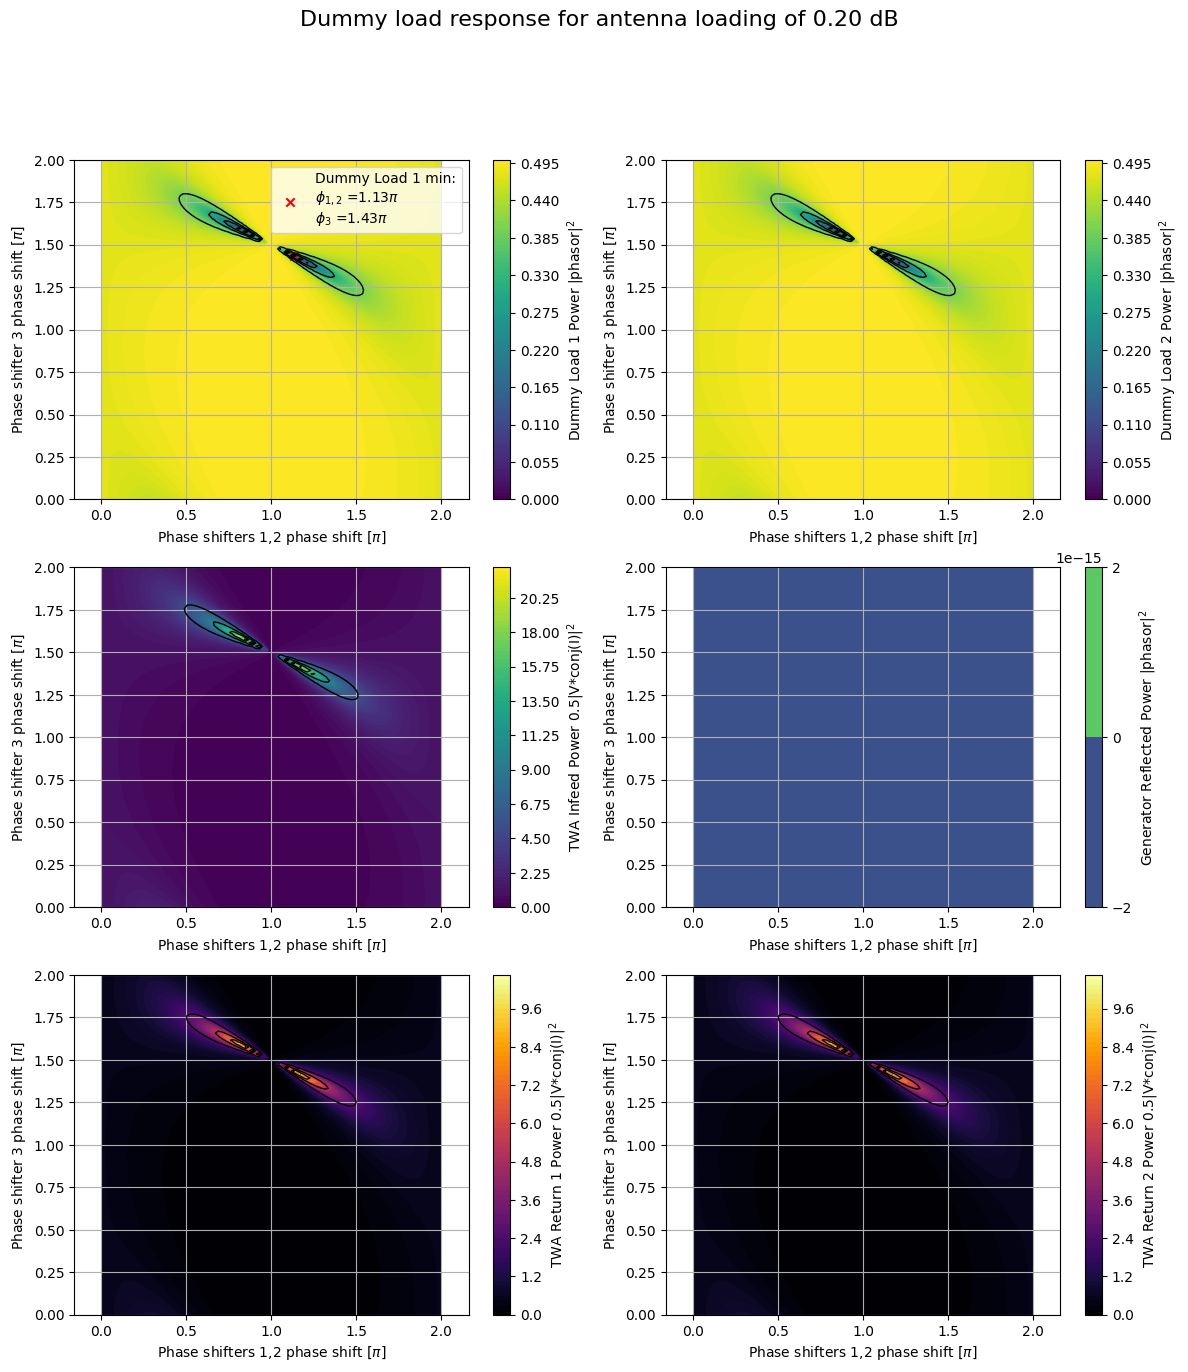

In [65]:
# plot the dummy loads 
levels = 4
print(phase_scan_matrix1.shape)
fig, ax = plt.subplots(3,2, figsize=(14,15))
fig.suptitle(f"Dummy load response for antenna loading of {load:.2f} dB", fontsize=16)

# DUMMY 1
ax[0,0].axis('equal')
cs = ax[0,0].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, dummy_load_mat1, levels=100)
cl = ax[0,0].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
    dummy_load_mat1,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[0,0].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[0,0].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[0,0].grid()
cbar = fig.colorbar(cs, ax=ax[0,0])
cbar.set_label(r"Dummy Load 1 Power |phasor|$^2$")  # label for the colorbar

# just for dummy1 1, find the minimum point 
min_val = dummy_load_mat1.min()
indices = np.where(dummy_load_mat1 == min_val)
i, j = indices[0][0], indices[1][0]

ax[0,0].scatter(phase_scan_matrix1[i,j]/np.pi, phase_scan_matrix2[i,j]/np.pi, 
                marker='x', 
                color='red', 
                label='Dummy Load 1 min:\n'+r'$\phi_{1,2}$ ='+f'{phase_scan_matrix1[i,j]/np.pi:.2f}'+r'$\pi$' \
                '\n' + r'$\phi_3$ ='+f'{phase_scan_matrix2[i,j]/np.pi:.2f}'+r'$\pi$')

ax[0,0].legend()


# DUMMY 2
ax[0,1].axis('equal')
cs = ax[0,1].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, dummy_load_mat2, levels=100)
cl = ax[0,1].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
    dummy_load_mat2,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[0,1].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[0,1].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[0,1].grid()
cbar = fig.colorbar(cs, ax=ax[0,1])
cbar.set_label(r"Dummy Load 2 Power |phasor|$^2$")  # label for the colorbar

# TWA FEED IN
ax[1,0].axis('equal')
cs = ax[1,0].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, twa_infeed_mat_cxn7, levels=100)
cl = ax[1,0].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
     twa_infeed_mat_cxn7,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[1,0].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[1,0].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[1,0].grid()
cbar = fig.colorbar(cs, ax=ax[1,0])
cbar.set_label(r"TWA Infeed Power 0.5|V*conj(I)|$^2$")  # label for the colorbar

# Generator reflections
ax[1,1].axis('equal')
cs = ax[1,1].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, generator_reflected_power_mat, levels=100)
cl = ax[1,1].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
    generator_reflected_power_mat,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[1,1].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[1,1].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[1,1].grid()
cbar = fig.colorbar(cs, ax=ax[1,1])
cbar.set_label(r"Generator Reflected Power |phasor|$^2$")  # label for the colorbar


# TWA Return power 1
ax[2,0].axis('equal')
cs = ax[2,0].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, twa_return_mat_cnx3, levels=100, cmap='inferno')
cl = ax[2,0].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
    twa_return_mat_cnx3,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[2,0].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[2,0].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[2,0].grid()
cbar = fig.colorbar(cs, ax=ax[2,0])
cbar.set_label(r"TWA Return 1 Power 0.5|V*conj(I)|$^2$")  # label for the colorbar

# TWA Return power 2
ax[2,1].axis('equal')
cs = ax[2,1].contourf(phase_scan_matrix1/np.pi, phase_scan_matrix2/np.pi, twa_return_mat_cnx4, levels=100, cmap='inferno')
cl = ax[2,1].contour(
    phase_scan_matrix1/np.pi,
    phase_scan_matrix2/np.pi,
    twa_return_mat_cnx4,
    levels=levels,            # number of line levels (or pass an array of values)
    colors="black",
    linewidths=1
)
ax[2,1].set_xlabel(r'Phase shifters 1,2 phase shift [$\pi$]')
ax[2,1].set_ylabel(r'Phase shifter 3 phase shift [$\pi$]')
ax[2,1].grid()
cbar = fig.colorbar(cs, ax=ax[2,1])
cbar.set_label(r"TWA Return 2 Power 0.5|V*conj(I)|$^2$")  # label for the colorbar


16

[1.00000000e+00 1.05931833e+00 1.10745662e+00 1.14007926e+00
 1.15304998e+00 1.14316016e+00 1.10889646e+00 1.05099857e+00
 9.72564629e-01 8.78608522e-01 7.75195901e-01 6.68449773e-01
 5.63725959e-01 4.65132075e-01 3.75401894e-01 2.96028212e-01
 2.27527093e-01 1.69730062e-01 1.22042867e-01 8.36460741e-02
 5.36360076e-02 3.11155522e-02 1.52474224e-02 5.28154689e-03
 5.65791125e-04 5.46676923e-04 4.76460353e-03 1.28464554e-02
 2.44973484e-02 3.94925087e-02 5.76697863e-02 7.89229958e-02
 1.03196074e-01 1.30477911e-01 1.60797593e-01 1.94219714e-01
 2.30839245e-01 2.70775326e-01 3.14163095e-01 3.61142344e-01
 4.11841435e-01 4.66354345e-01 5.24708169e-01 5.86817869e-01
 6.52424730e-01 7.21015457e-01 7.91720755e-01 8.63196937e-01
 9.33503004e-01 1.00000000e+00]
